# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». 

**Цель:** Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Задачи для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Содержание:
1. Загрузка данных 
4. Подготовка данных к моделированию
4. Обучение модели
5. Подготовка к расчету прибыли
6. Расчет прибыли
7. Расчет рисков
7. Общие выводы

Данные для работы:
    
1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
3. product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Импорт необходимых библиотек и констант:

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
RANDOM_STATE = 42
TEST_SIZE = 0.25

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    

## Загрузка данных

Загрузим данные двумя путями, для работы в локальном окружении или онлайн

In [2]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
    
dfs=[(geo_data_0, 'Регион_1'), (geo_data_1, 'Регион_2'), (geo_data_2, 'Регион_3')]    

Выведем общую информацию

In [3]:
def display_info_and_describe(dfs):
    for i, (df, filename) in enumerate(dfs):
        print(color.BOLD + f"DataFrame {i + 1} Файл: {filename}" + color.END)
        print(color.BOLD + "Info:"  + color.END)
        display(df.info())
        print(color.BOLD + "\nHead:" + color.END)
        display(df.head())
        print(f'\nПропуски: \n{df.isna().sum()}')
        print(f'\nДубликаты: \n{df.duplicated().sum()}')
        print(color.BOLD + 'END_OF_INFO' + color.END)
        print(' ')
display_info_and_describe(dfs)

DataFrame 1 Файл: Регион_1
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Head:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Пропуски: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты: 
0
END_OF_INFO
 
DataFrame 2 Файл: Регион_2
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Head:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Пропуски: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты: 
0
END_OF_INFO
 
DataFrame 3 Файл: Регион_3
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Head:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Пропуски: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубликаты: 
0
END_OF_INFO
 


По первичному обзору данных можно сделать следующие **выводы:** 

- Названия колонок таблицы в порядке
- Типы данных отвечают техническому заданию
- Пропусков нет
- Явных дубликатов нет
- Таблицы по трем регионам имеют сходный размер (100000 строк)


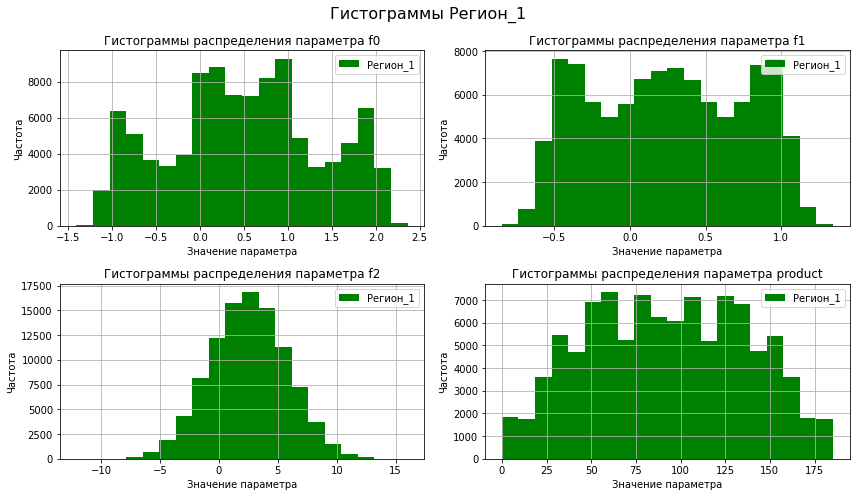

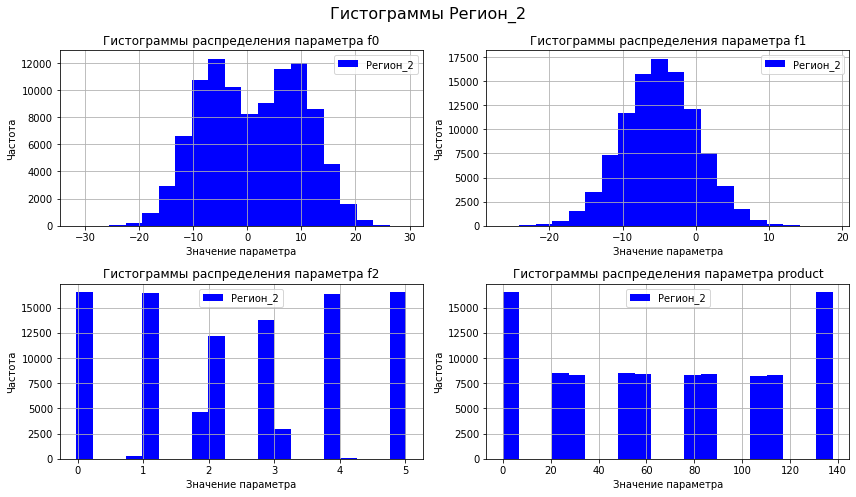

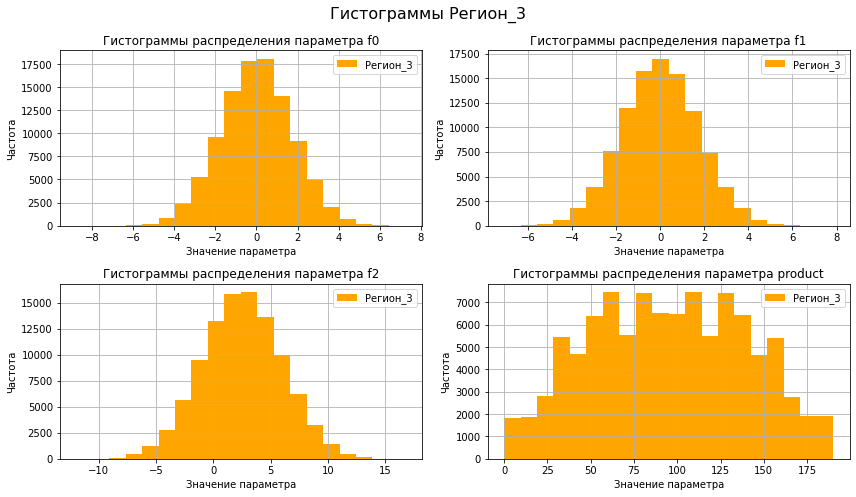

In [4]:
def graphs(df, filename, color):
    cols = ['f0', 'f1', 'f2', 'product']
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    for i, ax in zip(cols, axes):
        df[i].hist(bins=20, label=filename, stacked=False, ax=ax, color=color)
        ax.legend(loc='best')
        ax.set_xlabel('Значение параметра')
        ax.set_ylabel('Частота')
        ax.set_title(f'Гистограммы распределения параметра {i}')
    fig.suptitle(f'Гистограммы {filename}', fontsize=16)    

    plt.tight_layout()
    plt.show()

colors = ['green', 'blue', 'orange'] 
for (df, name), color in zip(dfs, colors): 
    graphs(df, name, color) 


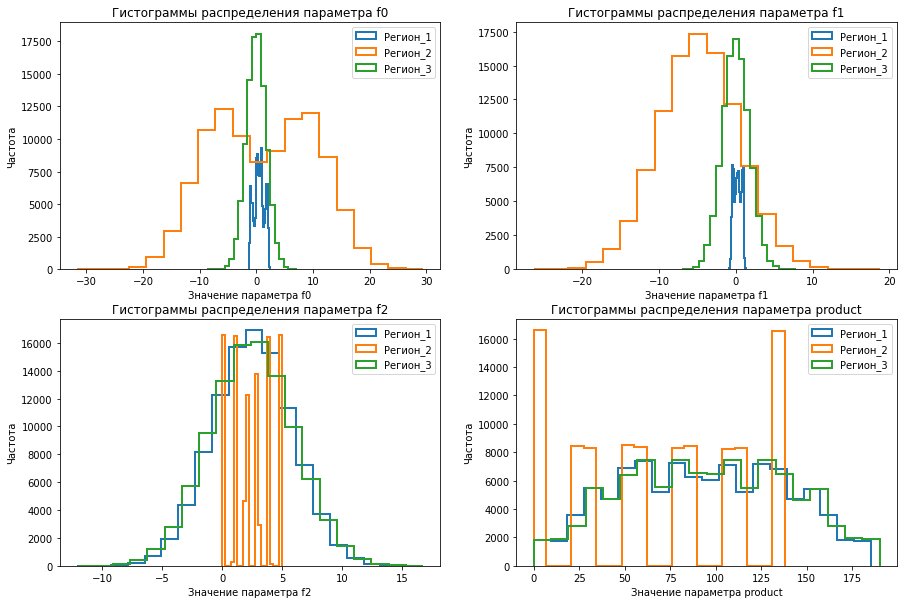

In [5]:
cols = ['f0', 'f1', 'f2', 'product']

fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()

for col, ax in zip(cols, axes):
    for df, filename in dfs:
        df[col].hist(bins=20, label=filename, ax=ax, histtype="step", linewidth=2)
        ax.legend(loc='best')
        ax.grid(False)
        ax.set_xlabel(f'Значение параметра {col}')
        ax.set_ylabel('Частота')
        ax.set_title(f'Гистограммы распределения параметра {col}')
          
plt.show()


Для 3 регионов построены гистограммы распределения параметров f0, f1, f2, отдельно опишу распределения параметров по каждому файлу:

1. geo_data_0: 
    1. Параметр f0 мультимодальное распределение вблизи 0
    2. Параметр f1 мультимодальное распределение вблизи 0
    3. Параметр f2 нормальное распределение
    4. Парамер product распределен нормально
2. geo_data_1:
    1. Параметр f0 бимодальное распределение
    2. Параметр f1 нормальное распределение
    3. Параметр f2 мультимодальное распледеление в диапазоне 0-5
    4. Парамер product имеет значительные выбросы
3. geo_data_2:
    1. Параметр f0 нормальное распределение
    2. Параметр f1 нормальное распределение
    3. Параметр f2 нормальное распределение
    4. Парамер product распределен нормально
    
Из-за разных типов распределений стандартные статистические критерии могут не работать.

В целом из-за сходных значений не обязательно применять масштабирование, также его не нужно применять из-за ненужности для требуемой модели Линейной Регрессии.

## Подготовка данных к моделированию

Функция для выявления прогнозных значений и RMSE

In [6]:
def preprocessing(df):
    X = df.drop(columns=['product', 'id'], axis=1)
    y= df['product']
    X_train, X_val, y_train, y_val = train_test_split(X,  y, random_state=RANDOM_STATE, test_size=TEST_SIZE)
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_val)
    mae = mean_absolute_error(y_val, predictions) 
    rmse = (np.sqrt(mae)).round(2)
    data = {
    'RMSE': [rmse],
    'СЗПС': [predictions.mean().round(2)],
    'Реальный средний запас сырья' : [y_val.mean().round(2)]
               
}    
    data = pd.DataFrame(data)
    saved_table = pd.DataFrame({'Actual': y_val, 'Predicted': predictions})
    return data, saved_table

## Обучение и проверка модели

Вызовем функцию в цикле и напечатем датафрейм

In [7]:
all_data = []
for geo_data, name in dfs:
    data, saved_table = preprocessing(geo_data)
    data['Регион'] = name
    all_data.append(data)
    
combined_data = pd.concat(all_data, ignore_index=True)
combined_data.rename(columns={'СЗПС': 'Cредний запас предсказанного сырья'})

,RMSE,Cредний запас предсказанного сырья,Реальный средний запас сырья,Регион
0,5.57,92.40,92.33,Регион_1
1,0.85,68.71,68.73,Регион_2
2,5.74,94.77,95.15,Регион_3


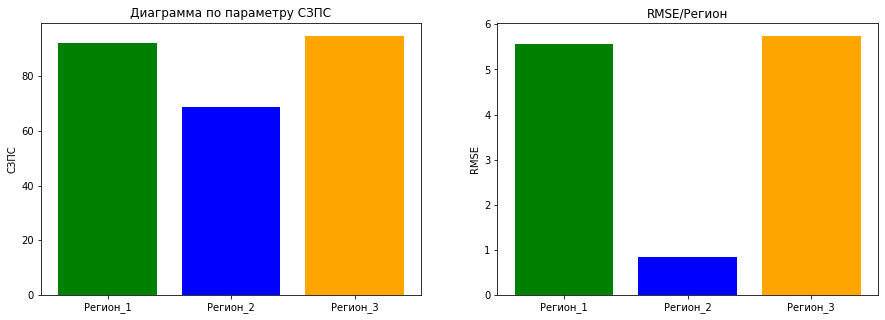

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes=axes.flatten()

axes[0].bar(combined_data['Регион'], combined_data['СЗПС'], color=['green', 'blue', 'orange'])
axes[0].set_ylabel('СЗПС')
axes[0].set_title('Диаграмма по параметру СЗПС')

axes[1].bar(combined_data['Регион'], combined_data['RMSE'], color=['green', 'blue', 'orange'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE/Регион');


По данным предсказаний можно сделать следующие **выводы**:

1. Средний запас сырья для 1 и 3 региона наибольший, более 90 тыс. баррелей
2. Для 1 и 3 региона выявлена высокая RMSE, метрика, которая измеряет среднеквадратичную ошибку между предсказанными значениями модели и фактическими значениями из данных. 

## Подготовка к расчёту прибыли

Введем константы, использование констант позволит значительно не менять код при изменении входных условий:

* ALL_POINTS = 500 Точки для Бутстрепинга
* BEST_POINTS = 200 200 лучших точек для разработки
* ALL_MONEY = 10000000000 бюджет разработки
* MONEY = 450000 стоимость барреля
* BOOTSTRAP = 1000 число создаваемых выборок

In [9]:
ALL_POINTS = 500
BEST_POINTS = 200
ALL_MONEY = 10_000_000_000
MONEY = 450000
BOOTSTRAP = 1000

Рассчитаем уровень неубыточности (по количеству баррелей) на регион, он рассчитавыется как частное бюджета и количества денег по продаже с 1 барреля. Т.к. бюджет ограничен, а мы должны выбрать 200 скважин из 500, то делим полученное значение на количество лучших скважин, таким образом скважина должна давать то число баррелей минимум, которое получится при 2 расчете.

In [12]:
print(color.BOLD + f"Уровень неубыточности: {round(ALL_MONEY/MONEY, 2)} баррелей на каждый регион.\n" + color.END)
print(color.BOLD + f"Объем нефти в скважине: {round(ALL_MONEY/MONEY/BEST_POINTS, 2)} \
баррелей в средней скважине на каждый регион.\n" + color.END)

Уровень неубыточности: 22222.22 баррелей на каждый регион.

Объем нефти в скважине: 111.11 баррелей в средней скважине на каждый регион.



Графически изорбразим средний предсказанный запас по регионам и уровень среднего объема нефти в скважине, при котором все предприятие неубыточно.

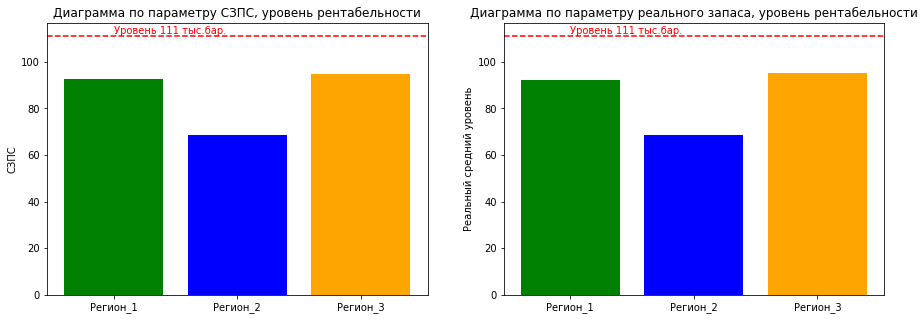

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  

ax[0].bar(combined_data['Регион'], combined_data['СЗПС'], color=['green', 'blue', 'orange'])
ax[0].set_ylabel('СЗПС')
ax[0].set_title('Диаграмма по параметру СЗПС, уровень рентабельности')
ax[0].axhline(y=111, color='r', linestyle='--')
ax[0].text(x=0, y=111, s='Уровень 111 тыс.бар.', color='r', va='bottom', ha='left')

ax[1].bar(combined_data['Регион'], combined_data['Реальный средний запас сырья'], color=['green', 'blue', 'orange'])
ax[1].set_ylabel('Реальный средний уровень')
ax[1].set_title('Диаграмма по параметру реального запаса, уровень рентабельности')
ax[1].axhline(y=111, color='r', linestyle='--')
ax[1].text(x=0, y=111, s='Уровень 111 тыс.бар.', color='r', va='bottom', ha='left')

plt.show()


Уровень неубыточности бизнеса: 22222.22 баррелей на каждый регион.

Объем нефти в скважине: 111.11 баррелей на каждый регион.

Промежуточный вывод: Ни по предсказанному, ни по реальному уровню скважины не дотягивают до уровня безубыточности

Вывод: Запас нефти в регионах недостаточен, в случае, если мы будем разрабатывать все скважины. Поэтому, необходимо выбрать 200 лучших, а в остальные не вкладываться.



## Расчёт прибыли 

In [ ]:
def sum_of_actual(geo_data):
    _, saved_table = preprocessing(geo_data)
    saved_table = saved_table.sort_values(by='Predicted', ascending=False).head(BEST_POINTS)
    return saved_table['Actual'].sum()

results_0 = sum_of_actual(geo_data_0)
results_1 = sum_of_actual(geo_data_1)
results_2 = sum_of_actual(geo_data_2)

Расчет прибыли производится по следующей формуле: 

```(Запас * стоимость барреля) - Затраты на разработку```

In [ ]:
table_of_profits = pd.DataFrame({
        'Регион': ['Регион_1', 'Регион_2', 'Регион_3'],
        'Сумма средних запасов лучших 200 скважин в каждом регионе (бар.)': \
    [results_0.round(2), results_1.round(2), results_2.round(2)],
    'Прибыль региона (млрд руб.)': \
    [(results_0.round(2)*MONEY - ALL_MONEY) / 1e9, (results_1.round(2)*MONEY - ALL_MONEY) / 1e9,\
     (results_2.round(2)*MONEY - ALL_MONEY) / 1e9]
})

table_of_profits['Прибыль региона (млрд руб.)'] = table_of_profits['Прибыль региона (млрд руб.)'].round(2)

display(table_of_profits)

plt.figure(figsize=(15, 6))
plt.bar(table_of_profits['Регион'], table_of_profits['Прибыль региона (млрд руб.)'], color=['green', 'blue', 'orange'])
plt.title('Столбчатая диаграмма по прибыли регионов')
plt.ylabel('Прибыль, млрд.руб.')
plt.xticks(rotation=45)
plt.show()

Вывод:
Отрицательной прибыли не наблюдается ни по одному региону, необходимо рассчитать риски вложений, чтобы выбрать наиболее выгодный регион.

## Расчёт рисков

Выведем в переменных сохраненные таблицы предсказаний и реальных значений

In [ ]:
_, results_0 = preprocessing(geo_data_0)
_, results_1 = preprocessing(geo_data_1)
_, results_2 = preprocessing(geo_data_2)

Пример

In [ ]:
results_0.head()

In [ ]:
state = np.random.RandomState(12345)
profit_data = []
dfs = [(results_0, 'Регион_1'), (results_1, 'Регион_2'), (results_2, 'Регион_3')]
for results, name in dfs:
    profit = []
    for i in range(BOOTSTRAP):
        data = results.sample(ALL_POINTS, replace=True, random_state=state)
        data['Profit'] = data['Actual'] * MONEY
        data = data.sort_values(by='Predicted', ascending=False).head(BEST_POINTS)
        profit.append(data['Profit'].sum() - ALL_MONEY)
    profit_series = pd.Series(profit)
    mean_profit = round(profit_series.mean() / 1e6, 2)
    confidence_interval = f"{round(profit_series.quantile(0.025) / 1e7, 2)} ... {round(profit_series.quantile(0.975) / 1e7, 2)}"
    risks = round((profit_series < 0).mean() * 100, 2)

    profit_data.append({
        'Регион': name,
        'Средняя прибыль, млн.руб.': mean_profit,
        'Доверительный интервал, млн.руб': confidence_interval,
        'Риски (%)': risks
    })

results_df = pd.DataFrame(profit_data)
results_df.head(5)

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(results_df['Регион'], results_df['Риски (%)'], color=['green', 'blue', 'orange'])
plt.title('Столбчатая диаграмма "Риски разработки в различных регионах"')
plt.ylabel('Риск, %')
plt.show()

Вывод:

0. Для расчета рисков в регионе применен метод Бутстрепинга, который имеет ряд преимуществ:
   1. Простота реализации: метод легко использовать и требует минимальных вычислений.
   2. Оценка неопределенности: позволяет оценить доверительные интервалы и стандартные ошибки.
   3. Гибкость: применим к различным статистическим задачам и распределениям.
   4. Не требует предположений о нормальности: подходит для данных с неизвестным распределением.
   5. Возможность работы с малыми выборками: эффективно использует доступные данные.
   
1. Наименьший риск разработки во 2 Регионе, только во 2 регионе риск менее 2.5 процентов
2. Доверительный интервал прибыли в этом регионе положительный - регион безубыточен.
3. Запасы в регионе 2 были наименьшими, несмотря на это, регион 2 наименее рискованный.


## Общие выводы

**Математическое моделирование позволило сделать выводы об потенциальной доходности региона разработки скважин №2, на первый взгляд покритериям средних значений запасов и прибыли регион не так привлекателен, как регионы 1 и 3, однако по параметру рисков регион 2 благоприятен (менее 2.5 процентов), поэтому для разработки рекомендуется именно он.**

В ходе работы на разных этапах были сделаты следуюие выводы:

**О данных:**

1. Названия колонок таблицы в порядке
2. Типы данных отвечают техническому заданию
3. Пропусков нет
4. Явных дубликатов нет
5. Таблицы по трем регионам имеют сходный размер (100000 строк)

**О типах распределений параметров:**

1. geo_data_0: 
    1. Параметр f0 мультимодальное распределение вблизи 0
    2. Параметр f1 мультимодальное распределение вблизи 0
    3. Параметр f2 нормальное распределение
    4. Парамер product распределен нормально
2. geo_data_1:
    1. Параметр f0 бимодальное распределение
    2. Параметр f1 нормальное распределение
    3. Параметр f2 мультимодальное распледеление в диапазоне 0-5
    4. Парамер product имеет значительные выбросы
3. geo_data_2:
    1. Параметр f0 нормальное распределение
    2. Параметр f1 нормальное распределение
    3. Параметр f2 нормальное распределение
    4. Парамер product распределен нормально
    
Из-за разных типов распределений стандартные статистические критерии могут не работать.

В целом из-за сходных значений не обязательно применять масштабирование, также его не нужно применять из-за ненужности для требуемой модели Линейной Регрессии.

**О запасах сырья в регионах:**

1. Средний запас сырья для 1 и 3 региона наибольший, более 90 тыс. баррелей
2. Для 1 и 3 региона выявлена высокая RMSE, метрика, которая измеряет среднеквадратичную ошибку между предсказанными значениями модели и фактическими значениями из данных. 

**О убыточности, достаточности запасов нефти:**

1. Уровень неубыточности бизнеса: 22222.22 баррелей на каждый регион.
2. Объем нефти в скважине: 111.11 баррелей на каждый регион.
3. Ни по предсказанному, ни по реальному уровню скважины не дотягивают до уровня безубыточности


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, проведено детальное исследование и был выбран правильный регион!
</div>



<div class="alert alert-block alert-info">
<b>Совет: </b> Если интересно изучить тему бутстрапа глубже - я оставлю  ниже несколько интересных и полезных ссылок по теме:
        
1. "Bootstrap Hypothesis Testing in Statistics with Example" 
        
https://www.youtube.com/watch?v=9STZ7MxkNVg
        
2. "How to Calculate Bootstrap Confidence Intervals For Machine Learning Results in Python" 
        
https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/
        
3. "A Gentle Introduction to the Bootstrap Method" 

https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/
        
4. "An Introduction to the Bootstrap Method" 
        
https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60#:~:text=The%20basic%20idea%20of%20bootstrap,population%20mean)%20on%20sample%20data.&amp;text=A%20sample%20from%20population%20with%20sample%20size%20n
        
5. "Bootstrapping and Resampling in Statistics with Example" 
        
        
https://www.youtube.com/watch?v=O_Fj4q8lgmc

6. Также одна из программ на рынке по этой теме управлненеческого моделирования - AnyLogic - интересный продукт. Можешь видео из интернета посмотреть по какому-нибудь примеру с её использованием. Тогда тема управленческого моделирования и бутстрапа может по-другому лечь.
</div>

